<a href="https://colab.research.google.com/github/mathdoyun/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 불러오기

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/data/img_align_celeba.zip" "."
!unzip "./img_align_celeba.zip" -d "./GAN/"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: ./GAN/img_align_celeba/197600.jpg  
 extracting: ./GAN/img_align_celeba/197601.jpg  
 extracting: ./GAN/img_align_celeba/197602.jpg  
 extracting: ./GAN/img_align_celeba/197603.jpg  
 extracting: ./GAN/img_align_celeba/197604.jpg  
 extracting: ./GAN/img_align_celeba/197605.jpg  
 extracting: ./GAN/img_align_celeba/197606.jpg  
 extracting: ./GAN/img_align_celeba/197607.jpg  
 extracting: ./GAN/img_align_celeba/197608.jpg  
 extracting: ./GAN/img_align_celeba/197609.jpg  
 extracting: ./GAN/img_align_celeba/197610.jpg  
 extracting: ./GAN/img_align_celeba/197611.jpg  
 extracting: ./GAN/img_align_celeba/197612.jpg  
 extracting: ./GAN/img_align_celeba/197613.jpg  
 extracting: ./GAN/img_align_celeba/197614.jpg  
 extracting: ./GAN/img_align_celeba/197615.jpg  
 extracting: ./GAN/img_align_celeba/197616.jpg  
 extracting: ./GAN/img_align_celeba/197617.jpg  
 extracting: ./GAN/img_align_celeba/197618.jpg  
 extracting: ./GAN/img_align_cele

# 데이터 살펴보기

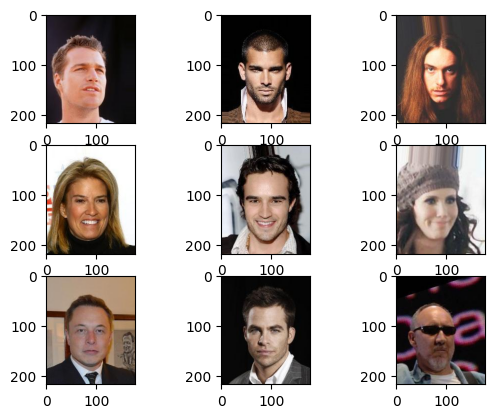

In [ ]:
import glob
import matplotlib.pyplot as plt
import os

from PIL import Image

# 이미지까지의 경로
pth_to_imgs = "./GAN/img_align_celeba"
imgs = glob.glob(os.path.join(pth_to_imgs, "*"))


# 9개의 이미지를 보여줌
for i in range(9):
   plt.subplot(3, 3, i+1)
   img = Image.open(imgs[i])
   plt.imshow(img)

plt.show()

# 이미지 전처리 정의

In [ ]:
import torch
import torchvision.transforms as tf

from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader


# ❶ 이미지의 전처리 과정
transforms = tf.Compose([
   tf.Resize(64),
   tf.CenterCrop(64),
   tf.ToTensor(),
   tf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# ❷ ImageFolder()를 이용해 데이터셋을 작성
# root는 최상위 경로를, transform은 전처리를 의미합니다.
dataset = ImageFolder(
   root="./GAN",
   transform=transforms
)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

# 생성자 정의

In [ ]:
import torch.nn as nn


class Generator(nn.Module):
   def __init__(self):
       super(Generator, self).__init__()

       # 생성자를 구성하는 층 정의
       self.gen = nn.Sequential(
           nn.ConvTranspose2d(100, 512, kernel_size=4, bias=False),
           nn.BatchNorm2d(512),
           nn.ReLU(),

           nn.ConvTranspose2d(512, 256, kernel_size=4,
                              stride=2, padding=1, bias=False),
           nn.BatchNorm2d(256),
           nn.ReLU(),

           nn.ConvTranspose2d(256, 128, kernel_size=4,
                              stride=2, padding=1, bias=False),
           nn.BatchNorm2d(128),
           nn.ReLU(),

           nn.ConvTranspose2d(128, 64, kernel_size=4,
                              stride=2, padding=1, bias=False),
           nn.BatchNorm2d(64),
           nn.ReLU(),

           nn.ConvTranspose2d(64, 3, kernel_size=4,
                              stride=2, padding=1, bias=False),
           nn.Tanh()
       )

   def forward(self, x):
       return self.gen(x)

# 감별자 정의

In [ ]:
class Discriminator(nn.Module):
   def __init__(self):
       super(Discriminator, self).__init__()

       # 감별자를 구성하는 층의 정의
       self.disc = nn.Sequential(
           nn.Conv2d(3, 64, kernel_size=4,
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(64),
           nn.LeakyReLU(0.2),

           nn.Conv2d(64, 128, kernel_size=4,
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(128),
           nn.LeakyReLU(0.2),

           nn.Conv2d(128, 256, kernel_size=4,
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(256),
           nn.LeakyReLU(0.2),

           nn.Conv2d(256, 512, kernel_size=4,
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(512),
           nn.LeakyReLU(0.2),

           nn.Conv2d(512, 1, kernel_size=4),
           nn.Sigmoid()
       )

   def forward(self, x):
       return self.disc(x)

# GAN의 가중치 초기화 함수

In [ ]:
def weights_init(m):
   # 층의 종류 추출
   classname = m.__class__.__name__
   if classname.find('Conv') != -1:
       # 합성곱층 초기화
       nn.init.normal_(m.weight.data, 0.0, 0.02)
   elif classname.find('BatchNorm') != -1:
       # 배치정규화층 초기화
       nn.init.normal_(m.weight.data, 1.0, 0.02)
       nn.init.constant_(m.bias.data, 0)

# 학습에 필요한 요소 정의

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# 생성자 정의
G = Generator().to(device)
# ❶ 생성자 가중치 초기화
G.apply(weights_init)

# 감별자 정의
D = Discriminator().to(device)
# ❷ 감별자 가중치 초기화
D.apply(weights_init)

import tqdm

from torch.optim.adam import Adam

G_optim = Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

# 학습 루프 정의

In [ ]:
for epochs in range(50):
   iterator = tqdm.tqdm(enumerate(loader, 0), total=len(loader))

   for i, data in iterator:
       D_optim.zero_grad()

       # ➊ 실제 이미지에는 1, 생성된 이미지는 0으로 정답을 설정
       label = torch.ones_like(
           data[1], dtype=torch.float32).to(device)
       label_fake = torch.zeros_like(
           data[1], dtype=torch.float32).to(device)

       # ➋ 실제 이미지를 감별자에 입력
       real = D(data[0].to(device))

       # ❸ 실제 이미지에 대한 감별자의 오차를 계산
       Dloss_real = nn.BCELoss()(torch.squeeze(real), label)
       Dloss_real.backward()
       # ➊ 가짜 이미지 생성
       noise = torch.randn(label.shape[0], 100, 1, 1, device=device)
       fake = G(noise)

       # 가짜 이미지를 감별자에 입력
       output = D(fake.detach())

       # 가짜 이미지에 대한 감별자의 오차를 계산
       Dloss_fake = nn.BCELoss()(torch.squeeze(output), label_fake)
       Dloss_fake.backward()

       # ➋ 감별자의 전체 오차를 학습
       Dloss = Dloss_real + Dloss_fake
       D_optim.step()
       # ➊ 생성자의 학습
       G_optim.zero_grad()
       output = D(fake)
       Gloss = nn.BCELoss()(torch.squeeze(output), label)
       Gloss.backward()

       G_optim.step()

       iterator.set_description(f"epoch:{epochs} iteration:{i} D_loss:{Dloss} G_loss:{Gloss}")

torch.save(G.state_dict(), "Generator.pth")
torch.save(D.state_dict(), "Discriminator.pth")

epoch:0 iteration:1582 D_loss:0.00037036079447716475 G_loss:8.680028915405273: 100%|██████████| 1583/1583 [08:42<00:00,  3.03it/s]
epoch:1 iteration:1582 D_loss:0.0016027081292122602 G_loss:7.815969467163086: 100%|██████████| 1583/1583 [08:39<00:00,  3.05it/s]
epoch:2 iteration:1582 D_loss:0.23373091220855713 G_loss:5.42098331451416: 100%|██████████| 1583/1583 [08:38<00:00,  3.06it/s]
epoch:3 iteration:1582 D_loss:0.5045961737632751 G_loss:1.8721972703933716: 100%|██████████| 1583/1583 [08:44<00:00,  3.02it/s]
epoch:4 iteration:1582 D_loss:0.38058575987815857 G_loss:2.8134374618530273: 100%|██████████| 1583/1583 [08:34<00:00,  3.08it/s]
epoch:5 iteration:1582 D_loss:1.0681989192962646 G_loss:1.1694551706314087: 100%|██████████| 1583/1583 [08:34<00:00,  3.08it/s]
epoch:6 iteration:1582 D_loss:0.510539710521698 G_loss:1.6961803436279297: 100%|██████████| 1583/1583 [08:35<00:00,  3.07it/s]
epoch:7 iteration:1582 D_loss:0.3319510519504547 G_loss:3.46103835105896: 100%|██████████| 1583/1583

KeyboardInterrupt: 

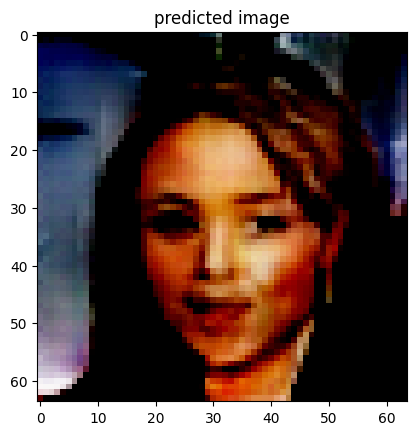

In [ ]:
with torch.no_grad():
   G.load_state_dict(
       torch.load("./Generator.pth", map_location=device))

   # 특징 공간 상의 랜덤한 하나의 점을 지정
   feature_vector = torch.randn(1, 100, 1, 1).to(device)
   # 이미지 생성
   pred = G(feature_vector).squeeze()
   pred = pred.permute(1, 2, 0).cpu().numpy()

   plt.imshow(pred)
   plt.title("predicted image")
   plt.show()